<a href="https://colab.research.google.com/github/andrew-nash/git-eireann/blob/main/GitEireann_Data_Exploration_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What's the aim?
Before we can make any predictions of anything, we need to understand what data we have been given. We will also find some more data, to help improve our understanding of the data we have.

# Quick note on the level of python programming
There is a lot of python in this notebook

The purpose of GitEireann is not to teach programming (but great if you learn some along the way). Further, we do not expect everyone to work in python.

The important thing to get from this notebook is the process that we follow. In this notebook, don't worry as much how we do plots, create arrays, process data etc - focus on why we do plots, what it is we are plotting, and what ideas we take from the plots.

It is entirely possible to take nearly all the key ideas of this notebook, and implement them in Microsoft Excel if you have no programming experience - let us know in the discussions channel if this is something you want to see.

Fintan has already put up a great text on plotting in R - if you want to try the analysis of this notebook in R, ggplot is a great way to easily create even more sophisticated, and better looking plots than this notebook.



# This Notebook
This is by no means an exhaustive, or indeed professional education on forecasting. This is supposed to give you a good starting point, to acta as a basis for making some accurate predictions for GitEireann. For this reason, if you have any doubts or questions about this notebook - let us know in the discussions channel.

Further, if you have some ideas on how we could improve this, let us know, or even do a pull request on GitHub (if that's something you know or want to do), and improve your chances for winning the best contributor prize!  

What this notebook will cover will be the identification of long term overall trends in Irish weather data, that will enable us to predict on a very coarse level the temperatures and humidities for our data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Load and visualise the training data


Download the train data from Kaggle, and upload in the left hand panel - alternatively, try running the cell below

In [2]:
!wget https://raw.githubusercontent.com/uccdatasoc/git-eireann/main/TrainData.csv

--2021-03-04 12:41:01--  https://raw.githubusercontent.com/uccdatasoc/git-eireann/main/TrainData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9379 (9.2K) [text/plain]
Saving to: ‘TrainData.csv’

TrainData.csv       100%[===================>]   9.16K  --.-KB/s    in 0s      

2021-03-04 12:41:01 (82.4 MB/s) - ‘TrainData.csv’ saved [9379/9379]



Lets read in the csv to a numpy array. We read as string to preserve the column of dates.

In [3]:
data = np.genfromtxt("TrainData.csv", delimiter=',', skip_header=1, dtype='str')

To work with the temperature and humidity columns, we convert them to float.


In [4]:
temps = np.array(data[:,1], dtype='float')
rhum = np.array(data[:,2], dtype='float')

The first order of business is always to plot the data.

Check out Finatn's GGplot tutorial in R for more advanced and sophisticated plotting, that will allow you to draw more conclusions from your plots, and format them better visually.

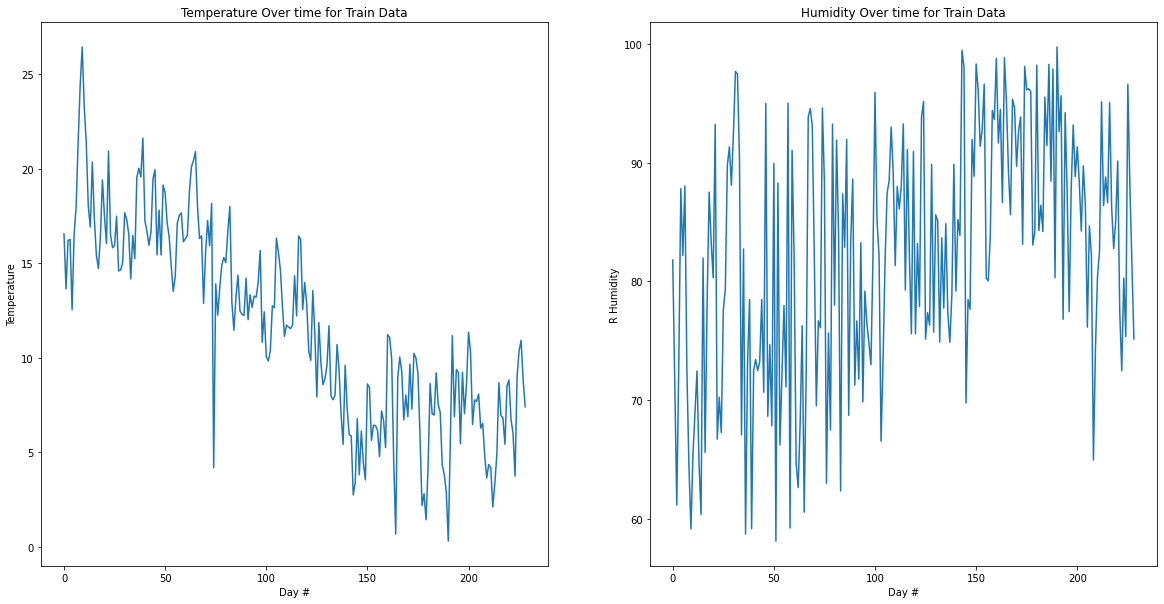

In [13]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(temps)
ax[0].set_title("Temperature Over time for Train Data")
ax[1].set_title("Humidity Over time for Train Data")
ax[0].set_ylabel("Temperature")
ax[1].plot(rhum)
ax[1].set_ylabel("R Humidity")
ax[0].set_xlabel("Day #")
ax[1].set_xlabel("Day #")
plt.show()

There is a lot of fluctuation going on in the above plots.

It may well be that these short term fluctuations are predictable, but that will be something we will look at later. 

For now, lets focus on long term trends.

We can use a simple moving average to smooth out these fluctuations, while preserving the overall trend of the data.

A moving average is exactly what it sounds like - each element in the smooted array is the average of a number of elements in the series.

For a simple moving average of window size 2k+1
\begin{equation}
  smooth[i] = \frac{1}{2k+1}\sum_{j=-k}^{k}data[i+j]
\end{equation}

You can have a weighted moving average, defined like
\begin{equation}
  smooth[i] = \frac{1}{2k+1}\sum_{j=-k}^{k}W_j\;data[i+j]
\end{equation}

Where you could have, for example, W = [1/16, 1/16, 1/4, 1/4, 1/4, 1/16, 1/16] for a moving averge with window size 7. This would out increased weight on more recent (or closely following) points in the average. Note that this weight array should be symmetric, and ***must sum to 1***. Otherwise, you are chaning the trend of the data, and scaling it respectively.

I leave the weighted smoothing as something for you to try yourself, the below work only involves simple weighted moving averages. 

In [15]:
# technically, this is half the window size, but not much difference 
def smoothMa(arr, window_size):
    n = len(arr)
    ans = []
    for i in range(n-window_size):
      ans.append(np.mean(arr[i:i+window_size]))
    return np.array(ans)


In [16]:
# smoothing of a 15 day window
smooth_temps = smoothMa(temps, 7)
smooth_rhum = smoothMa(rhum, 7)

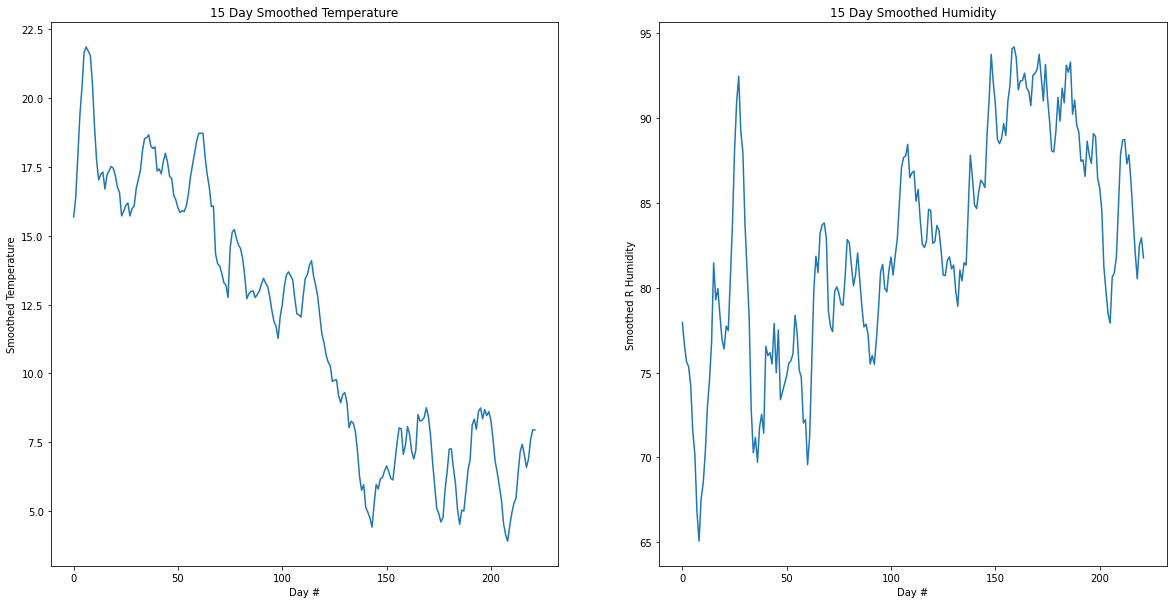

In [19]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(smooth_temps)
ax[0].set_title("15 Day Smoothed Temperature")
ax[1].set_title("15 Day Smoothed Humidity")
ax[0].set_ylabel("Smoothed Temperature")
ax[1].plot(smooth_rhum)
ax[1].set_ylabel("Smoothed R Humidity")
ax[0].set_xlabel("Day #")
ax[1].set_xlabel("Day #")
plt.show()

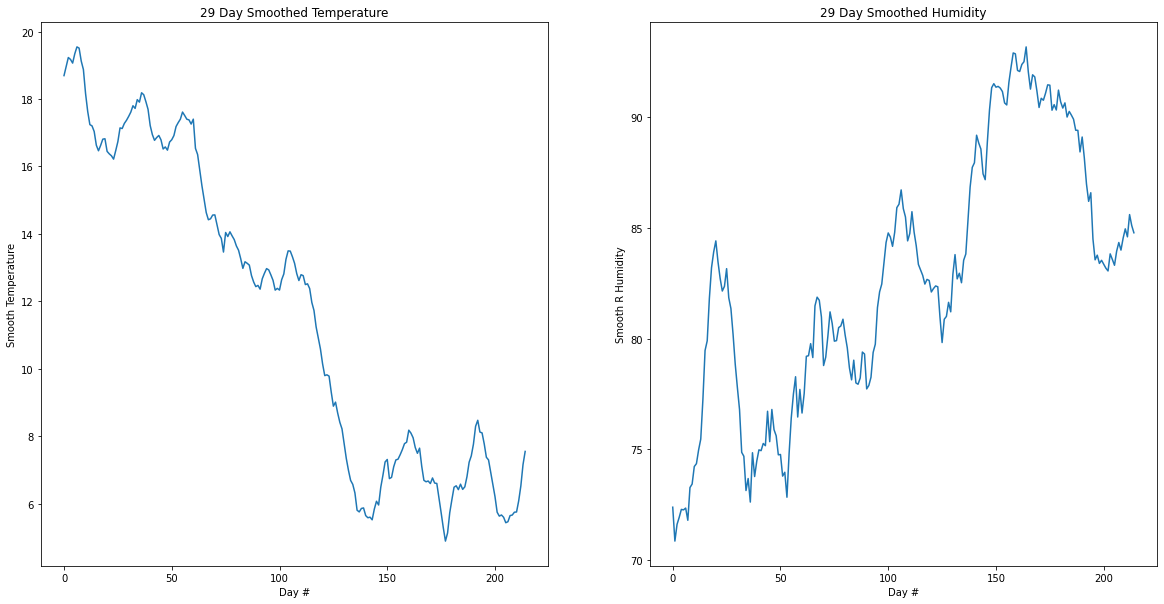

In [20]:
# much more aggressive smoothing, 29 day window
smooth_temps = smoothMa(temps, 14)
smooth_rhum = smoothMa(rhum, 14)
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(smooth_temps)
ax[0].set_title("29 Day Smoothed Temperature")
ax[1].set_title("29 Day Smoothed Humidity")
ax[0].set_ylabel("Smooth Temperature")
ax[1].plot(smooth_rhum)
ax[1].set_ylabel("Smooth R Humidity")
ax[0].set_xlabel("Day #")
ax[1].set_xlabel("Day #")
plt.show()

The above smoothing might be too aggressive to be useful for making any reliable predictions based on.

The results might be better with weighted moving averages.

We now want to add dates to the x-axis, in order to figure out what portion of the year each aspect of the plot corresponds to.

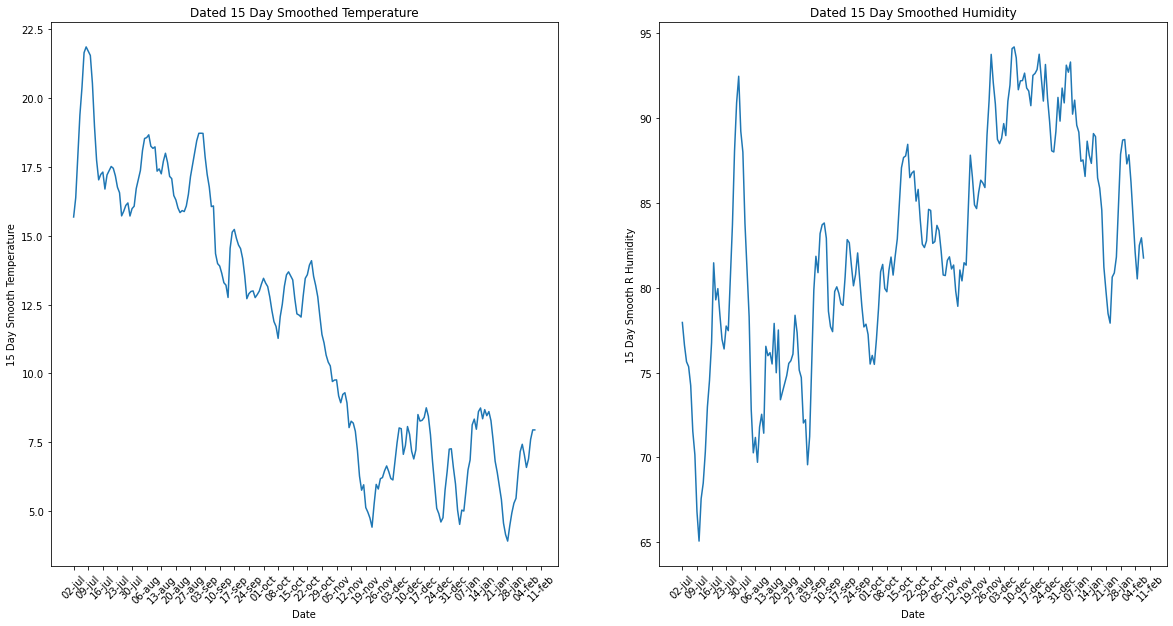

In [21]:
smooth_temps = smoothMa(temps, 7)
smooth_rhum = smoothMa(rhum, 7)
# lets take every seventh date
# having a tick on the plot for every date is too chaotic
# one per week is a nice balance
xlabs = data[0::7,0]
# the positions of each tick on the axis, specify intervals
# of size 7
pos = [i*7 for i in range(len(xlabs))]
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(smooth_temps)
ax[0].set_title("Dated 15 Day Smoothed Temperature")
ax[1].set_title("Dated 15 Day Smoothed Humidity")
ax[0].set_ylabel("15 Day Smooth Temperature")
ax[0].set_xticks(pos)
ax[0].set_xticklabels(xlabs, rotation=45)
ax[1].plot(smooth_rhum)
ax[1].set_ylabel("15 Day Smooth R Humidity")
ax[1].set_xticks(pos)
ax[1].set_xticklabels(xlabs, rotation=45)
ax[0].set_xlabel("Date")
ax[1].set_xlabel("Date")
plt.show()

So, overall the temperature seems to be declining between the end of August and mid November, where it fluctuates around low temperatures.

Humidity rises overall in the same period but shows signs of dropping in early January.

# Learn about Irish weather trends in gerneral from Cork data


We are looking to make predictions about the next two weeks after the end of the data. To do this, we are going to have to look at data about this time of year in general and compare it to earlier times in the year.

So, lets get some more data, to help our un derstanding of Irish weather in general. For example, lets take daily weather data from Cork airport. This is **not** the same as the [private dataset](https://youtu.be/oHg5SJYRHA0?t=19) as the Kaggle data we use for testing - that would be slightly pointless. This is just to help our qualitive understanding of what it is we are modelling (some aspects of weather). 

[Get the data here! (make sure to chose the csv)](https://data.gov.ie/dataset/cork-airport-hourly-data)

Upload it as before

Or, try running the cell below

In [22]:
!wget https://raw.githubusercontent.com/uccdatasoc/git-eireann/main/hly3904.csv

--2021-03-04 12:48:56--  https://raw.githubusercontent.com/uccdatasoc/git-eireann/main/hly3904.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22798822 (22M) [text/plain]
Saving to: ‘hly3904.csv’

hly3904.csv         100%[===================>]  21.74M  44.8MB/s    in 0.5s    

2021-03-04 12:48:58 (44.8 MB/s) - ‘hly3904.csv’ saved [22798822/22798822]



Read the csv as before 

In [23]:
cork_data = np.genfromtxt("hly3904.csv", delimiter=',', skip_header=24, dtype='str')

There are a whole load of different parameters measured at this staion, we only care about the date, temperature and relative humidity

In [24]:
cork_rhum = cork_data[:,9]
cork_temp = cork_data[:,4]
cork_datetime = cork_data[:,0]

Further, we only care about the *average daytime* temperature and relative humidity, so go ahead and average them over, say, 1100 to 1800 or a similar range.

In [25]:
# Discard any temps or rhums outside of the time range we specify
day_rhum = []
day_temp = []
date     = []
for d in range(len(cork_datetime)):
  time = cork_datetime[d][12:]
  if time>="11:00" and time<="18:00":
    day_rhum.append((cork_rhum[d])+'.0')
    day_temp.append((cork_temp[d]))
    date.append(cork_datetime[d][:11])
day_rhum = np.array(day_rhum, dtype='float')
day_temp = np.array(day_temp, dtype='float')
date     = np.array(date)

In [26]:
# average the values for each day
avg_rhum = []
avg_temp = []
avg_date = []

lastdate = ""
i = 0
running_h = 0
running_t = 0
count = 0
while i<len(date):
  while i<len(date)-1 and lastdate == date[i]:
    running_h+=day_rhum[i]
    running_t+=day_temp[i]
    count+=1
    i+=1
  
  if lastdate!="":
    avg_rhum.append(running_h/count)
    avg_temp.append(running_t/count)
    avg_date.append(lastdate)
  count = 1
  lastdate = date[i]
  running_t = day_temp[i]
  running_h = day_rhum[i]
  i+=1
avg_rhum = np.array(avg_rhum)
avg_temp = np.array(avg_temp)
avg_date = np.array(avg_date)

Again, plot all the data.

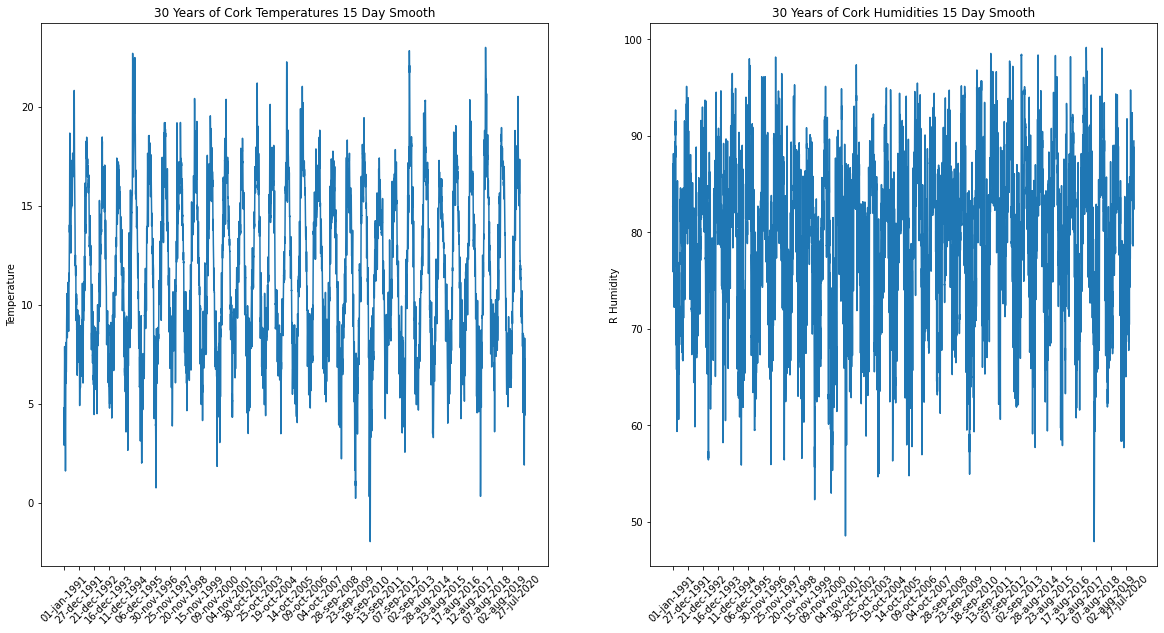

In [28]:
smooth_temps = smoothMa(avg_temp, 7)
smooth_rhum = smoothMa(avg_rhum, 7)
xlabs = avg_date[0::360]
pos = [i*360 for i in range(len(xlabs))]
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].set_title("30 Years of Cork Temperatures 15 Day Smooth")
ax[1].set_title("30 Years of Cork Humidities 15 Day Smooth")
ax[0].plot(smooth_temps)
ax[0].set_ylabel("Temperature")
ax[0].set_xticks(pos)
ax[0].set_xticklabels(xlabs, rotation=45)
ax[1].plot(smooth_rhum)
ax[1].set_ylabel("R Humidity")
ax[1].set_xticks(pos)
ax[1].set_xticklabels(xlabs, rotation=45)
plt.show()

In [29]:
len(avg_date)

10989

There are 30 years of data, up to pretty close to the present date.

This is too broad a range to notice any clear annual patterns, our outlook is too broad. As we only care about predicting two weeks of data at the end of a given year, and don't know what year it is, we can largely ignore the year-on-year trends, and focus on the patterns in an individual year.

So, lets go ahead and look at the last few years.

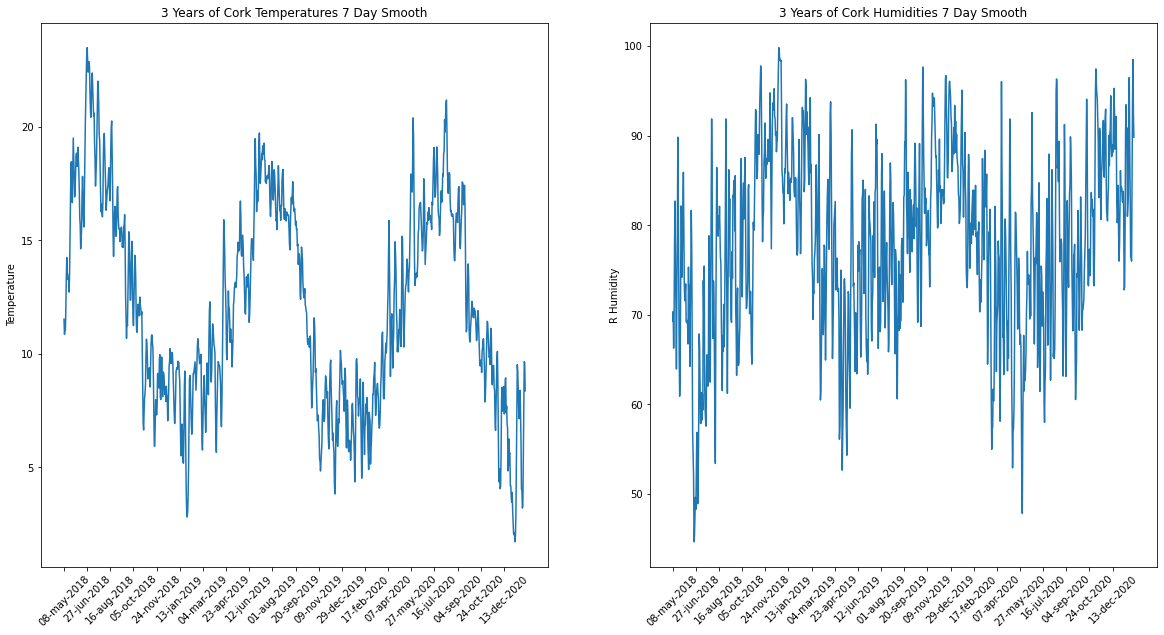

In [30]:
# take the last 1000 days, roughly 3 years
smooth_temps = smoothMa(avg_temp[-1000:], 3)
smooth_rhum = smoothMa(avg_rhum[-1000:], 3)
xlabs = avg_date[-1000::50]
pos = [i*50 for i in range(len(xlabs))]
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].set_title("3 Years of Cork Temperatures 7 Day Smooth")
ax[1].set_title("3 Years of Cork Humidities 7 Day Smooth")
ax[0].plot(smooth_temps)
ax[0].set_ylabel("Temperature")
ax[0].set_xticks(pos)
ax[0].set_xticklabels(xlabs, rotation=45)
ax[1].plot(smooth_rhum)
ax[1].set_ylabel("R Humidity")
ax[1].set_xticks(pos)
ax[1].set_xticklabels(xlabs, rotation=45)
plt.show()

This demonstrates a very clear, predictable annual cycle.

Lets now compare the cycles of different years, to see how regular they are.

Note that our train data starts on Jun 02. Lets use this as the start date of years we are considering, to allow us to translate ideas and models more easily from the Cork data to the train data.

In [ ]:
# find all the points in the data corresponding
# to Jun 02
starts = [0]
for d in range(len(avg_date)):
  if avg_date[d][:6]=="02-jun":
    starts.append(d)
starts = np.array(starts)


In [ ]:
starts

array([    0,   152,   518,   883,  1248,  1613,  1979,  2344,  2709,
        3074,  3440,  3805,  4170,  4535,  4901,  5266,  5631,  5996,
        6362,  6727,  7092,  7457,  7823,  8188,  8553,  8918,  9284,
        9649, 10014, 10379, 10745])

Lets plot 6 years of (unsmoothed) temperatures and relative humidities, starting from Jun 2 of each year.

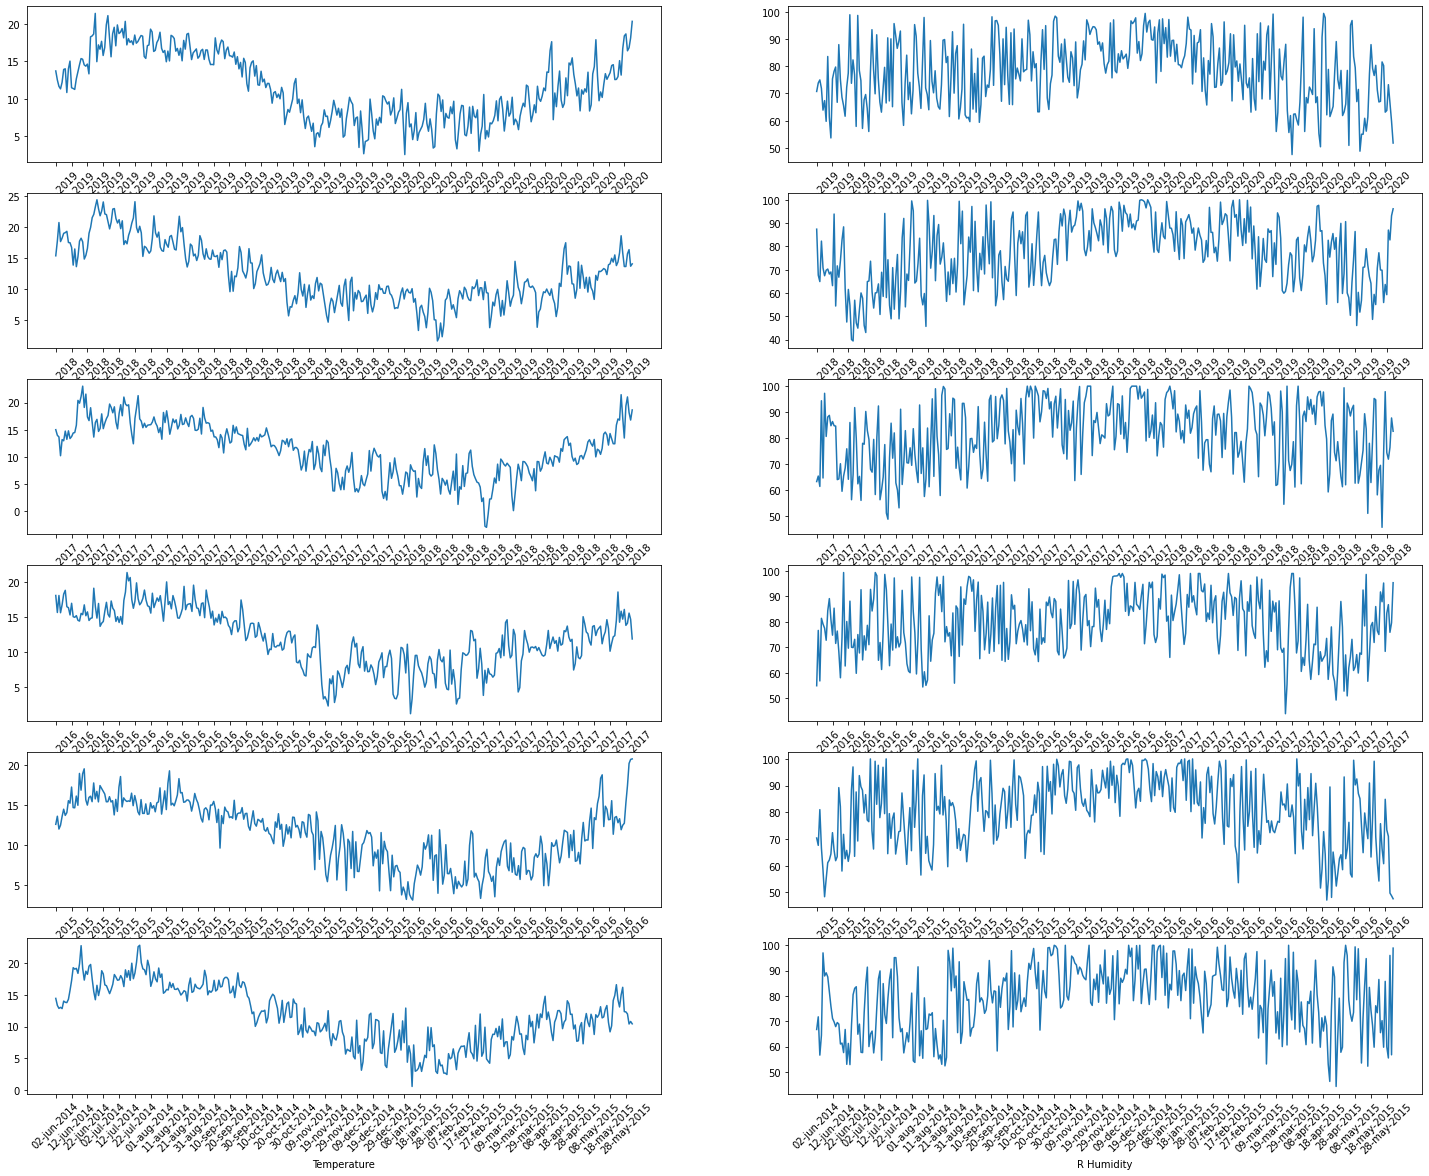

In [ ]:
YEARS = 6
fig, ax = plt.subplots(YEARS,2, figsize=(25,20))

for i in range(YEARS):
  xlabs = avg_date[starts[-1*(2+i)]:starts[-1*(i + 1)]][::10]
  pos = [i*10 for i in range(len(xlabs))]
  ax[i][0].plot(avg_temp[starts[-1*(i + 2)]:starts[-1*(i + 1)]])
  ax[i][0].set_xlabel("Temperature")
  ax[i][0].set_xticks(pos)
  ax[i][0].set_xticklabels(xlabs, rotation=45)
  ax[i][1].plot(avg_rhum[starts[-1*(i + 2)]:starts[-1*(i + 1)]])
  ax[i][1].set_xlabel("R Humidity")
  ax[i][1].set_xticks(pos)
  ax[i][1].set_xticklabels(xlabs, rotation=45)


The pattern appears strong, and pretty consistent between years, with some fluctuation and deviation.

We won't worry about trying to model this, or quantify it in any way, we just want to be aware it exists.

Lets plot our train data in exactly the same way as the above plots. As we don't have a full year of train data, we 'pad' or fill the x axis with some extra space.

In [ ]:
np.pad(np.array([12,3]),(0,2))

array([12,  3,  0,  0])

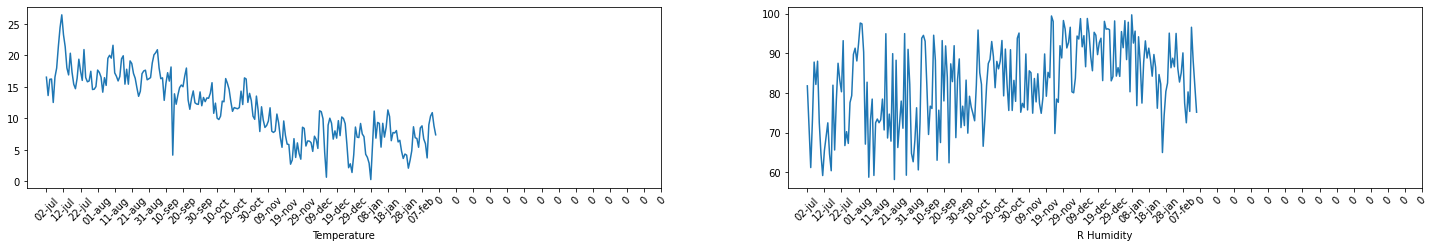

In [ ]:
  fig, ax = plt.subplots(1,2, figsize=(25,20/6))
  # the .pad adds some extra blank x axis labels
  xlabs = np.pad(data[:,0],(0,365-len(data[:,0])))[::10]
  pos = [i*10 for i in range(len(xlabs))]
  ax[0].plot(temps)
  ax[0].set_xlabel("Temperature")
  ax[0].set_xticks(pos)
  ax[0].set_xticklabels(xlabs, rotation=45)
  ax[1].plot(rhum)
  ax[1].set_xlabel("R Humidity")
  ax[1].set_xticks(pos)
  ax[1].set_xticklabels(xlabs, rotation=45)
  None

Now, lets smooth our Cork data a bit. In order to look at things a bit differently, for variety, we will consider all 30 years of smoothed data, and overlay the plots for each year.

This will give us a quick and easy way to visualise year-on-year changes.

Instead of using simple moving averages, here we can just take the average for each week, and have ~52 points per year instead of 365, reducing some fluctuation.

Try this with different smoothing and see what results you get.

In [ ]:
weekly_rhum = []
weekly_temp = []
week_start_date = []
# do a simple weekly average
for i in range(0, len(avg_date)-7, 7):
  week_start_date.append(avg_date[i])
  weekly_rhum.append(np.mean(avg_rhum[i:i+7]))
  weekly_temp.append(np.mean(avg_temp[i:i+7]))


weekly_rhum = np.array(weekly_rhum)
weekly_temp = np.array(weekly_temp)
week_start_date = np.array(week_start_date)

In [ ]:
# this is a bit messy
# we can't guarantee that 2nd June is the first day in the week
# so we have to define our year start point as roughly the first week of June
#
# In practice, we just find the index of the first values which are labelled with
# June each year
s = []
for d in range(len(week_start_date)):
  if week_start_date[d][2:6]=="-jun":
    s.append(d)
s = np.array(s)
s

array([  22,   23,   24,   25,   74,   75,   76,   77,   78,  126,  127,
        128,  129,  130,  179,  180,  181,  182,  231,  232,  233,  234,
        283,  284,  285,  286,  335,  336,  337,  338,  387,  388,  389,
        390,  391,  439,  440,  441,  442,  443,  492,  493,  494,  495,
        544,  545,  546,  547,  596,  597,  598,  599,  648,  649,  650,
        651,  700,  701,  702,  703,  704,  753,  754,  755,  756,  805,
        806,  807,  808,  857,  858,  859,  860,  909,  910,  911,  912,
        961,  962,  963,  964,  965, 1013, 1014, 1015, 1016, 1017, 1066,
       1067, 1068, 1069, 1118, 1119, 1120, 1121, 1170, 1171, 1172, 1173,
       1222, 1223, 1224, 1225, 1274, 1275, 1276, 1277, 1278, 1327, 1328,
       1329, 1330, 1379, 1380, 1381, 1382, 1431, 1432, 1433, 1434, 1483,
       1484, 1485, 1486, 1535, 1536, 1537, 1538, 1539])

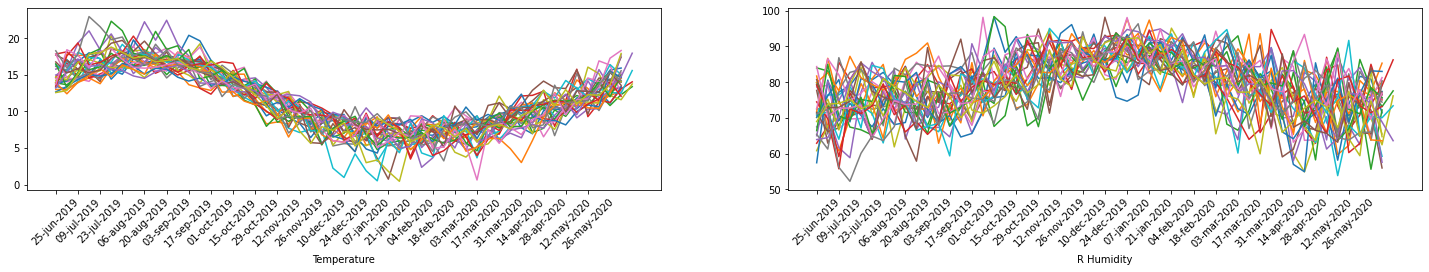

In [ ]:
  fig, ax = plt.subplots(1,2, figsize=(25,20/6))
  xlabs = week_start_date[1486:1535][::2]
  pos = [i*2 for i in range(len(xlabs))]

  ax[0].set_xlabel("Temperature")
  ax[0].set_xticks(pos)
  ax[0].set_xticklabels(xlabs, rotation=45)
  
  ax[1].set_xlabel("R Humidity")
  ax[1].set_xticks(pos)
  ax[1].set_xticklabels(xlabs, rotation=45)
  # I manually extracted the indices from above
  # You could have some nice code to do this, and should
  # if you change anything else above
  s = [22,74,126,179,231,283,335,387,439,492,544,596,648,700,753,805,857,909,961,1013,1066,1118,1170,1222,1274,1327,1379,1431,1483,1535]
  for i in range(1, len(s)):
    ax[0].plot(weekly_temp[s[i-1]:s[i]])
    ax[1].plot(weekly_rhum[s[i-1]:s[i]])
  None

These graphs speak for themselves. There is a lot of variation, but most of the temperatures are tightly concentrated on a sinusoidal looking curve +- 5 degrees.

relative humidity is much more variable, but interestingly, is much less variable in wintertime (it's variability is clearly and predictably variable itself).  

This largely concludes the long term exploration of the data.

We have yet to look at any short term behaviours, and trying to find patterns in the fluctuations, this will be the subject of a later notebook.

# Modelling

Making specific predictions is not the purpose of this notebook, but I will breifly introduce it for anyone who may be interested.

Much more useful, rigorous and accurate methods exist than this.

In [ ]:
weekly_temp, weekly_rhum
from scipy import optimize

When fitting a basic sine curve, we need to help things along a little bit.

We can use **least squares optimisation** to find the best paramaters of a sine curve to match our data.

This works best if we start with initial values that are rational, and form a since curve that is visible close to what we expect the optimal result to be.

We won't get into the different algorithms for optimization, if you do want to find out more, Google it, or raise the topic in discussions

There is a lot of manual adjustment required to get good resuts here.

Note we only use the last 300 weeks below. Thats becasue that , over longer timeframes, the period of the waveform seems to change slightly. Try removing the ```[-300:]``` below, or altering the 300 to 500, 600, 900, etc.

(5.4111668996144004, 0.12122157570892633, 11.630724060442258)

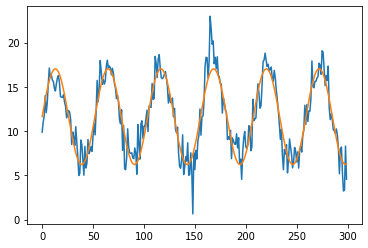

In [ ]:
x = np.arange(len(weekly_temp[-300:]))
y = weekly_temp[-300:]

def sin_fit(x, a, b, c):
  return c+a*np.sin(b*x)

(fitted_a, fitted_b, fitted_c), _ = \
optimize.curve_fit(sin_fit, x, y, p0=[5, 0.12, 3],bounds=[(1,0.0001,-1),(6,0.2,20)])
fitted_a, fitted_b, fitted_c
all_temps_model = sin_fit(x, fitted_a, fitted_b, fitted_c)
plt.plot(x, y)
plt.plot(x, all_temps_model)
fitted_a, fitted_b, fitted_c

Now, lets try apply this sine function (paramaters (5.4111668996144004, 0.12122157570892633, 11.630724060442258)) from above to our train data 

The sine wave is for weekly data, so we divide the period by 7.

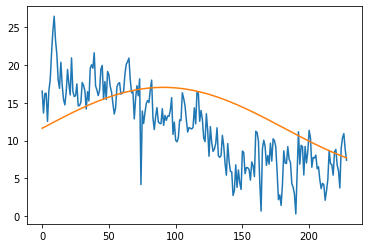

In [ ]:
plt.plot(temps)
plt.plot(sin_fit(np.arange(len(temps)), fitted_a, fitted_b/7, fitted_c))

We have to adjust the start point of the range to fit the data we have.

We could do this by hand, or using an optimisation method like the above.

In this case, when we just want to minimise a single scalar cost, we can use the scipy minimize_scalar function. If you are interested in the maths of this, this optimises our fit using Brent's method, which you can Google.

We would use the scipy minimize function, if we had a vector of paramaters that we are minimizing accross.

72.08154739539847

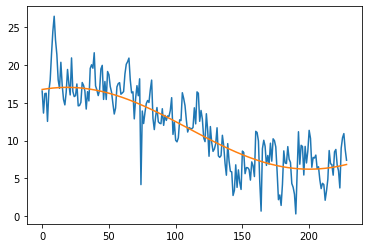

In [ ]:
def match_train(start):
  preds = sin_fit(np.arange(int(start), int(start)+len(temps)), fitted_a, fitted_b/7, fitted_c)
  return np.sqrt(np.mean((preds-temps)**2))

s = (optimize.minimize_scalar(match_train, bounds=[(-150,150)])).x
plt.plot(temps)
plt.plot(sin_fit(np.arange(int(s), int(s)+len(temps)), fitted_a, fitted_b/7, fitted_c))
s

So, running this for 16 more values

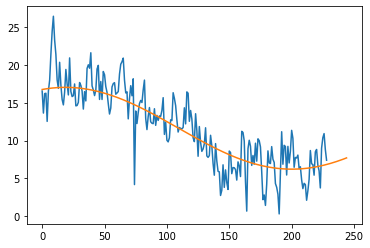

In [ ]:
plt.plot(temps)
plt.plot(sin_fit(np.arange(int(s), int(s)+len(temps)+16), fitted_a, fitted_b/7, fitted_c))

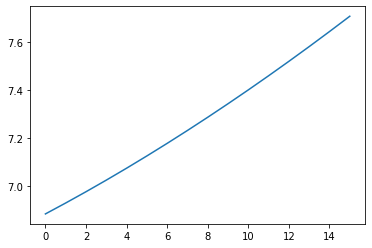

In [ ]:
preds=sin_fit(np.arange(int(s), int(s)+len(temps)+16), fitted_a, fitted_b/7, fitted_c)[-16:]
plt.plot(preds)

Lets submit this as our very first (probably not very good)prediction

I'll leave applying this exact same technique to the relative humidities as an excercise - but we can discuss anything you're not sure about in the discussions channel

Eyeballing the earlier graphs suggest humidities of 80% are typical for February, so ...

In [ ]:
dates = np.array(["15-feb","16-feb","17-feb","18-feb","19-feb","20-feb","21-feb","22-feb","23-feb","24-feb","25-feb","26-feb","27-feb","28-feb","01-mar","02-mar"])
predicted_temps = preds
predicted_hums = np.array([80.0 for i in range(len(preds))])

In [ ]:
# a neat way to join arrays as columns
out_data = np.array([dates, predicted_temps, predicted_hums]).T
np.savetxt("sine_temp_pred.csv", out_data, delimiter=',', header="id,Temperature,RelativeHumidity", fmt=("%s","%s","%s"),comments='')

Go ahead and download the csv we just created on the left

Go to kaggle.com/c/uccdata, click My Submissions, and now make your first GitEireann submission!



*Note about savetxt*
There are a few things to unpack in the savetxt line


```
delimiter=','
```
This makes the file a csv (comma separated values) file, which is clear enough.

```
header="id,Temperature,RelativeHumidity"
```
This line sets the header of the csv, and is of the **exact** format that we need to be accepted by the Kaggle judging system.

```
fmt=("%s","%s","%s")
```
We have two different types of data in our array, strings and floats. As a result, when we created the single ```out_data``` array, it converted the floats to a (Unicode) string. This %s line just tells numpy that it should expect the format of the data given to be strings.

```
comments=''
```
If we don't include this, numpy adds a # to the beginning of the csv, which Kaggle interprets as part of the header, and rejects the submission as a result


This gives a score of ~6.6 - which is actually not too bad, considering the (relative) simplicity of it.

# Next Steps

We will continue to release notebooks like this exploring different ideas

Mick Cooney, an expert Data Scientist from Describe Data will be giving a talk on data exploration on March 3rd, if you are interested, I would strongly recommend attending.

Ask questions about this, and GitEireann in general in the Discord channels - the more discussion and engagement that happens, the more we will all learn.